In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 3MD3220: Reinforcement Learning Individual Assignment
## Text-Flappy-Bird RL Agent
Antonine Batifol

# Environment Load and libraries import

In [ ]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

In [3]:
import os
import sys
import gymnasium as gym
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import text_flappy_bird_gym
from tqdm import tqdm
import pandas as pd
import itertools
import time
from matplotlib import patches as mpatches

## fix seed
np.random.seed(42)

## flappybird env settings
HEIGHT = 15
WIDTH = 20
PIPE_GAP = 4

# Process observations to return state in proper format depending on the environment used
def process_observation(obs, mode):
    if mode == "distance":
        return tuple(obs)  # (x_distance, y_distance)
    elif mode == "screen":
        if isinstance(obs, np.ndarray):
            obs = ''.join(chr(x) for x in obs.flatten())
        lines = obs.split('\n')
        for row, line in enumerate(lines):
            if 'O' in line:
                col = line.index('O')
                return (row, col)
    return None

# The Environments


We are provided with two environments:
 - The TextFlappyBird-screen env where the state is represented as a 2D grid (2D array) where each cell/element corresponds to a part of the screen (e.g., player, pipes, walls).

 - The TextFlappyBirdSimple-env, which returns only the horizontal and vertical distances between the player and the center of the closest upcoming pipe gap.

The screen environment is more complex and may require, the state space is larger and require more computational resources for an agent to properly learn.
That's why I will focus on the simple environment when training a Monte-Carlo and a Sarsa($\lambda$) Agent for faster computation even if it does not provide a full context to the agent.

 We display both of these environments below.

In [ ]:
# Example for the screen environment
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()
action = env.action_space.sample()
obs, reward, done, _, info = env.step(action)
print(obs.T)
os.system("clear")
sys.stdout.write(env.render())
time.sleep(0.2) # FPS
env.close()

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]]
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[    

In [ ]:
# Example for the simple environment for a whole game
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, _, info = env.step(action)
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-6)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-7)
Text Flappy Bird!
Score: 0
----------------------
[     

# Agents Implementation
## Monte-Carlo Agent

The Monte-Carlo Agent is based on **episodic learning** and Q-values are updated
**only at the end of each episodes**.

1. **Play an entire episode**
2. **Compute the cumulative discounted reward**
3. **Update Q-values**: $$ Q_{t+1}(a,s) = Q_{t}(a,s) + \alpha (G - Q_{t}(a,s))$$
where G is the sum of the discounted rewards of the episode
4. **Repeat for multiple episodes** to refine Q estimates.

The MC agent implemented here uses an $\epsilon$-greedy policy to perform the simulation for each episode. Its perfomance depends on the following parameters:
* $\alpha$: the learning rate for Q update
* $\gamma$: the discount rate
* $\epsilon$ and $\epsilon$-decay: control the trade-off between exploration and exploitation in the $\epsilon$-greedy policy

These parameters will be tuned later

In [4]:
class MCAgent:
    def __init__(self, mode, epsilon=1.0, gamma=0.99, alpha=0.1, epsilon_decay=0.999):
        if mode == "distance":
            env = gym.make('TextFlappyBird-v0', height=HEIGHT, width=WIDTH, pipe_gap=PIPE_GAP)
        elif mode == "screen":
            env = gym.make('TextFlappyBird-screen-v0', height=HEIGHT, width=WIDTH, pipe_gap=PIPE_GAP)
        else:
            raise ValueError("Invalid mode. Must be 'distance' or 'screen'.")
        self.env = env
        self.nA = env.action_space.n
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.alpha = alpha
        self.Q = {}
        self.mode = mode


    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.nA)
        possible_actions = np.where(self.Q.get(state, np.zeros(self.nA)) == np.max(self.Q.get(state, np.zeros(self.nA))))[0]
        return np.random.choice(possible_actions)

    def update_q(self, episode):
        G = 0
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward

            # add unvisited state to Q
            if state not in self.Q:
                self.Q[state] = np.zeros(self.nA)

            # update Q value
            self.Q[state][action] += self.alpha * (G - self.Q[state][action])
        self.epsilon *= self.epsilon_decay

    def train_agent(self, num_episodes=5000):
        rewards = []
        scores = []
        counter = 0
        for episode in tqdm(range(num_episodes)):
            state = process_observation(self.env.reset()[0], self.mode)
            action = self.epsilon_greedy_policy(state)
            total_reward = 0
            done = False
            episode_memory = []
            while not done:
                next_state, reward, done, _, info = self.env.step(action)
                next_state = process_observation(next_state, self.mode)
                next_action = self.epsilon_greedy_policy(next_state)
                episode_memory.append((state, action, reward))
                state, action = next_state, next_action
                total_reward += reward

                ## The episode is stopped when the agent reaches a score of 10000 to avoid too long training times since the agents could theoritically play forever
                if info['score'] > 10000:
                    counter +=1
                    print(f'The Agent reward has reached 10000 score for {counter} times')
                    if counter > 1000:
                        self.update_q(episode_memory)
                        rewards.append(total_reward)
                        scores.append(info['score'])
                        return rewards, scores
                    break
            # Update Q at the end of each episode
            self.update_q(episode_memory)
            rewards.append(total_reward)
            scores.append(info['score'])
        return rewards, scores

We first train our Monte-Carlo agent with default parameters to observe the progression of rewards over time.  

Next, we set $\epsilon$ to 0 to assess the agent's performance in actual games. This ensures that actions are selected purely based on a greedy policy, focusing solely on exploitation rather than exploration. We then evaluate its average performance over 10 games.

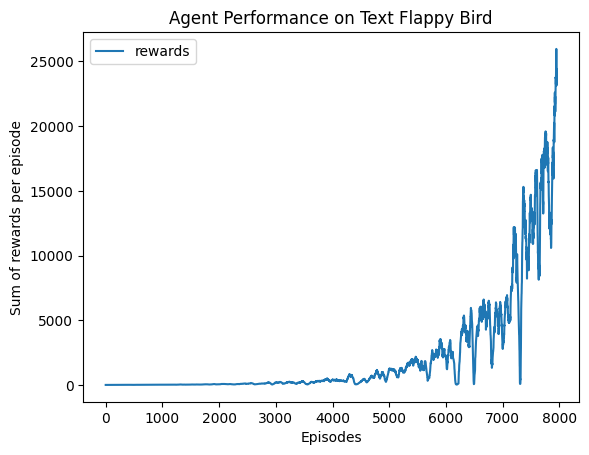

The agent reached a average score of 10006.0 and an average reward 100064.0 


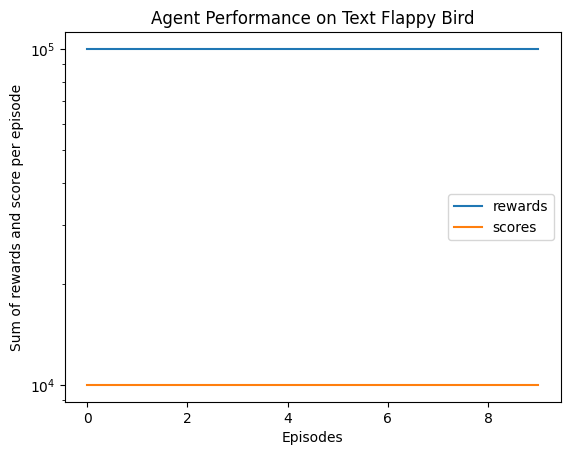

In [ ]:
## ------------- Agent Training ---------------- ##
#Train the agent for 8000 episodes
mc_agent = MCAgent(mode="distance")
rewards_mc, scores_mc = mc_agent.train_agent(num_episodes=8000)
print(f"$\epsilon$ has decayed from 1 to {mc_agent.epsilon}")
# we apply some kind of rolling mean to smooth the plot
window = 50
mc_avg_reward = np.convolve(rewards_mc, np.ones(window)/window, mode='valid')
mc_avg_score = np.convolve(scores_mc, np.ones(window)/window, mode='valid')
mc_results = {"rewards":rewards_mc, "scores":scores_mc}
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/base3_mc_training.json', 'w') as f:
  json.dump(mc_results, f)


plt.plot(mc_avg_reward, label='rewards')
# plt.plot(mc_avg_score, label='scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/MC_base3_training.jpg')
plt.show()


## ------------- Agent Evaluation ---------------- ##
## set epsilon to 0.0 to only use a greedy policy
rewards = []
scores = []

for _ in range(10):
  mc_agent.epsilon = 0.0
  state = process_observation(mc_agent.env.reset()[0], mc_agent.mode)
  action = mc_agent.epsilon_greedy_policy(state)
  counter = 0
  total_reward = 0
  while True:
      next_state, reward, done, _, info = mc_agent.env.step(action)
      total_reward += reward
      next_state = process_observation(next_state, mc_agent.mode)
      next_action = mc_agent.epsilon_greedy_policy(next_state)
      state, action = next_state, next_action
      if info['score'] > 10000:
          counter+=1
          # print(f"The Agent reached a score > 10000 (score: {info['score']}, reward: {total_reward}) for the {counter} times")
          if counter > 50:
              break
      if done:
          break

  scores.append(info['score'])
  rewards.append(total_reward)
plt.plot(rewards[:], label='rewards')
plt.plot(scores[:], label='scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards and score per episode')
plt.yscale('log')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()

print(f"The agent reached a average score of {np.mean(scores)} and an average reward {np.mean(rewards)} ")

## **Sarsa(λ) Agent**
Sarsa(λ) is an **on-policy, step-by-step learning algorithm** that combines **Temporal Difference (TD) Learning** with **eligibility traces**.

1. Take an action using an **ε-greedy** policy.
2. Observe the reward and next state.
3. Choose the next action using the same **ε-greedy** policy.
4. Compute the TD error:  
   $$
   \delta = R + \gamma Q(S', A') - Q(S, A)
   $$
5. **Update Q-values using eligibility trace**: The Q-values are updated **at every step** using traces that decay over time. The trace allows the agent to learn from both recent and past experiences.
  $ e(s,a) = e(s,a)+1$ where e is the eligibility trace.

  Then for all s,a:
  $$ Q(s,a) = Q(s,a) + \alpha \delta e(s,a)$$
  $$e(s,a) = \gamma \lambda e(s,a)$$
6. Repeat for every step until the episode ends.

Unlike the Monte-Carlo Agent, the Sarsa($\lambda$) Agent updates the Q-value continuously during an episode using bootstraping to estimate future rewards. This is supposed to help the agent learning faster.

In [5]:
class SarsaLambdaAgent:
    def __init__(self, gamma=0.99, alpha=0.1, epsilon=1.0, lambda_=0.9, epsilon_decay=0.999, mode='distance'):
        if mode == "distance":
            env = gym.make('TextFlappyBird-v0', height=HEIGHT, width=WIDTH, pipe_gap=PIPE_GAP)
        elif mode == "screen":
            env = gym.make('TextFlappyBird-screen-v0', height=HEIGHT, width=WIDTH, pipe_gap=PIPE_GAP)
        else:
            raise ValueError("Invalid mode. Must be 'distance' or 'screen'.")
        self.env = env
        self.nA = env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.epsilon_decay = epsilon_decay
        self.Q = {}
        self.E = {}
        self.mode = mode

    def epsilon_greedy_policy(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.nA)
        possible_actions = np.where(self.Q.get(state, np.zeros(self.nA)) == np.max(self.Q.get(state, np.zeros(self.nA))))[0]
        return np.random.choice(possible_actions)

    def update_q(self, state, action, reward, next_state, next_action, done):
        # add unvisited state to Q
        if state not in self.Q:
            self.Q[state] = np.zeros(self.nA)
        if next_state not in self.Q:
            self.Q[next_state] = np.zeros(self.nA)

        delta = reward + (self.gamma * self.Q[next_state][next_action] * (1 - done)) - self.Q[state][action]
        self.E[(state, action)] = self.E.get((state, action), 0) + 1
        for (s, a) in self.E:
            self.Q[s][a] += self.alpha * delta * self.E[(s, a)]
            self.E[(s, a)] *= self.gamma * self.lambda_

    def train_agent(self, num_episodes=5000):
        rewards = []
        scores = []
        counter = 0
        for episode in tqdm(range(num_episodes)):
            state = process_observation(self.env.reset()[0], self.mode)
            action = self.epsilon_greedy_policy(state)
            total_reward = 0
            done = False

            while not done:
                next_state, reward, done, _, info = self.env.step(action)
                next_state = process_observation(next_state, self.mode)

                # we use the variable done in the Q update to now his there is a next state to consider or not
                next_action = self.epsilon_greedy_policy(next_state)
                self.update_q(state, action, reward, next_state, next_action, done)
                state, action = next_state, next_action
                total_reward += reward

                if info['score'] > 10000:
                    counter+=1
                    print(f'The Agent reward has reached 10000 score for {counter} times')
                    if counter > 50:
                        rewards.append(total_reward)
                        scores.append(info['score'])
                        return rewards, scores
                    break
            self.epsilon *= self.epsilon_decay
            rewards.append(total_reward)
            scores.append(info['score'])
        return rewards, scores

We first train our Sarsa($\lambda$) agent with the same default parameters to observe the progression of rewards over time.

Next, we set  ϵ  to 0 to assess the agent's performance in actual games. This ensures that actions are selected purely based on a greedy policy, focusing solely on exploitation rather than exploration. We then evaluate its average performance over 10 games.

In [ ]:
## ------------- Agent Training ---------------- ##
#Train the agent for 10000 episodes
sarsa_agent = SarsaLambdaAgent(mode="distance", lambda_=0.5,alpha=0.1, epsilon_decay=0.999, gamma=0.99, epsilon=1.0 )
rewards_sarsa, scores_sarsa = sarsa_agent.train_agent(num_episodes=10000)
window = 50
sarsa_avg_reward = np.convolve(rewards_sarsa, np.ones(window)/window, mode='valid')
sarsa_avg_score = np.convolve(scores_sarsa, np.ones(window)/window, mode='valid')

sarsa_results = {"rewards":rewards_mc, "scores":scores_mc}
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/results_sarsa_base/sarsa_base_training.json', 'w') as f:
            json.dump(sarsa_results, f)

plt.plot(sarsa_avg_reward, label='rewards')
plt.plot(sarsa_avg_score, label='scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results_sarsa_base/sarsa_base_training.jpg')
plt.show()


## ------------- Agent Evaluation ---------------- ##
## set epsilon to 0.0 to only use a greedy policy
rewards= []
scores = []

for _ in range(10):
  ## set epsilon to 0.0 to only use a greedy policy
  sarsa_agent.epsilon = 0.0
  state = process_observation(sarsa_agent.env.reset()[0], sarsa_agent.mode)
  action = sarsa_agent.epsilon_greedy_policy(state)
  counter = 0
  total_reward = 0
  while True:
      next_state, reward, done, _, info = sarsa_agent.env.step(action)
      total_reward += reward
      next_state = process_observation(next_state, sarsa_agent.mode)
      next_action = sarsa_agent.epsilon_greedy_policy(next_state)
      state, action = next_state, next_action
      if info['score'] > 10000:
          print(f"The Agent reached a score > 10000 (score: {info['score']}, reward: {total_reward}) for the {counter} times")
          if counter > 50:
              break
      if done:
          break
      scores.append(info['score'])
      rewards.append(total_reward)

print(f"The agent reached a score of {np.mean(scores)} and reward {np.mean(rewards)} ")

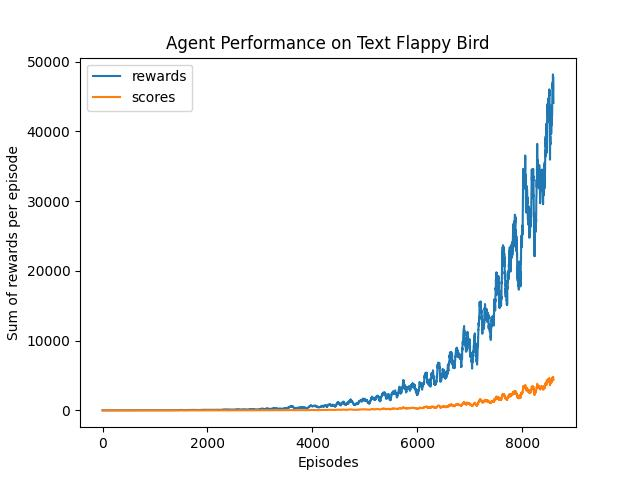

In [ ]:
from PIL import Image

# Load image
image = Image.open('/content/drive/MyDrive/3A-CS/RL/Assignement/results_sarsa_base/sarsa_base_training.jpg')

# Display image
image

Overall the scores for both agents and all tests and trainings were around 10 times lower. I just assumed that scores were incremented by +1 whenever a pipe was passed while the bird was rewarded of +1 for each next succesful step. To train our sarsa agent we need reward at each step. However for the MC agent we could also try to use the end score to update Q.

### Comparison of Agents' training performance with default parameters

In [ ]:
with open('/content/drive/MyDrive/3A-CS/RL/Assignement/results_sarsa_base/base_sarsa_training.json', 'r') as f:
    sarsa_results = json.load(f)

rewards_sarsa = sarsa_results["rewards"]
scores_sarsa = sarsa_results["scores"]

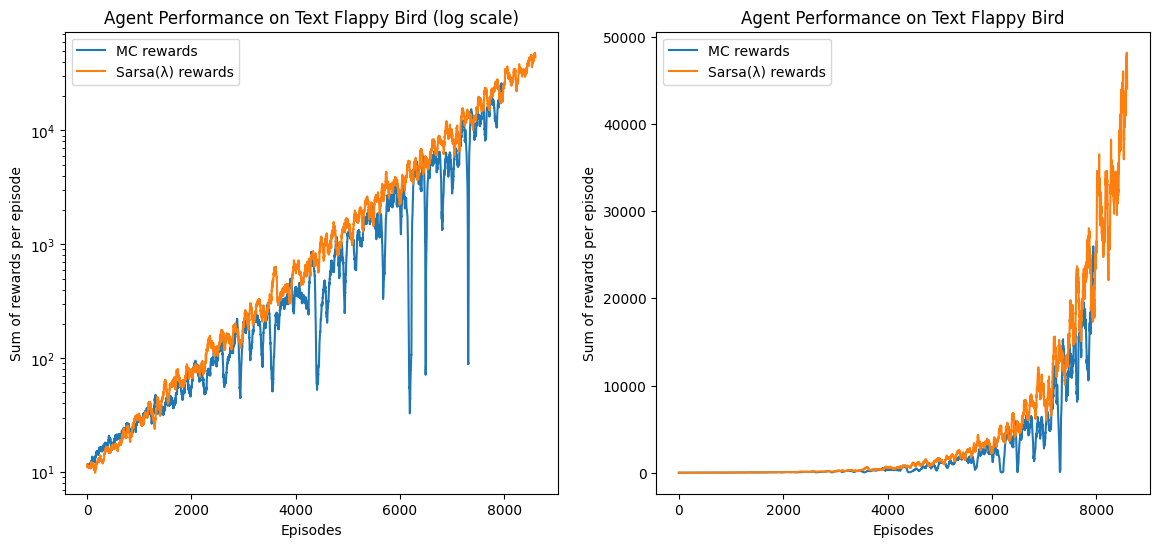

In [ ]:
# Assuming rewards_mc, scores_mc, rewards_sarsa, and scores_sarsa exist
window = 50
mc_avg_reward = np.convolve(rewards_mc, np.ones(window)/window, mode='valid')
mc_avg_score = np.convolve(scores_mc, np.ones(window)/window, mode='valid')
sarsa_avg_reward = np.convolve(rewards_sarsa, np.ones(window)/window, mode='valid')
sarsa_avg_score = np.convolve(scores_sarsa, np.ones(window)/window, mode='valid')

# Set figure size before subplots
plt.figure(figsize=(14, 6))  # Change width and height here

plt.subplot(1, 2, 1)
plt.plot(mc_avg_reward, label='MC rewards')
# plt.plot(mc_avg_score, label='MC scores')
plt.plot(sarsa_avg_reward, label='Sarsa(λ) rewards')
# plt.plot(sarsa_avg_score, label='Sarsa(λ) scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.yscale('log')
plt.title('Agent Performance on Text Flappy Bird (log scale)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mc_avg_reward, label='MC rewards')
# plt.plot(mc_avg_score, label='MC scores')
plt.plot(sarsa_avg_reward, label='Sarsa(λ) rewards')
# plt.plot(sarsa_avg_score, label='Sarsa(λ) scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()

plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/comparison_base_training.jpg')
plt.show()


Note that the sarsa agent was trained for 9000 episodes while the MC agent was trained only for 8000 episodes.
With the default parameters both agents seem to perform quite similarly, indicating need for farther parameters tuning. However it seems like the MC Agents rewards display more instability. It is due to the higher variance caused by the update of Q only at the end of each episode. It does not appear that the Sarsa Lambda agent learns faster than the MC agent as we could have expected.

## Policy and state-value function
Let's now observe the policy generated by these two agents with default parameters. Remember that only 2 actions are possible in each state: flap or idle.

In [ ]:
def plot_policy_with_actions(agent1,agent1name, agent2,agent2name, mode, filename):
    """
    Plots the policies learned by two Monte Carlo agents, showing where the agents flap, idle,
    and which states are unvisited.
    """
    agentname = [agent1name,agent2name]
    color_map = {
        0: 'blue',    # Idle
        1: 'green',   # Flap
        -1: 'gray'    # Unvisited
    }

    # Define numerical mapping for colors
    color_indices = {
        'idle': 0,
        'flap': 1,
        'unvisited': -1
    }


    if mode == "distance":
        x_dist_max = WIDTH - int(WIDTH * 0.3) - 1
        y_dist_max = HEIGHT - 1 - int(PIPE_GAP / 2) - 1
        x_dist_range = range(x_dist_max + 1)
        y_dist_range = range(-y_dist_max, y_dist_max + 1)

        X, Y = np.meshgrid(x_dist_range, y_dist_range)

        # Initialize policy and visited arrays for both agents
        policies = [np.zeros_like(X, dtype=int), np.zeros_like(X, dtype=int)]
        visited = [np.zeros_like(X, dtype=bool), np.zeros_like(X, dtype=bool)]

        for idx, agent in enumerate([agent1, agent2]):
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    state = (X[i, j], Y[i, j])
                    if state in agent.Q:
                        best_action = np.argmax(agent.Q[state])
                        visited[idx][i, j] = True
                    else:
                        best_action = -1  # Mark unvisited states with -1
                    policies[idx][i, j] = best_action

    elif mode == "screen":
        # Initialize policy and visited arrays for both agents
        policies = [np.zeros((HEIGHT, WIDTH), dtype=int), np.zeros((HEIGHT, WIDTH), dtype=int)]
        visited = [np.zeros((HEIGHT, WIDTH), dtype=bool), np.zeros((HEIGHT, WIDTH), dtype=bool)]

        for idx, agent in enumerate([agent1, agent2]):
            for x in range(HEIGHT):
                for y in range(WIDTH):
                    state = (x, y)
                    if state in agent.Q:
                        best_action = np.argmax(agent.Q[state])
                        visited[idx][x, y] = True
                    else:
                        best_action = -1  # Mark unvisited states with -1
                    policies[idx][x, y] = best_action

    else:
        raise ValueError("Invalid mode. Must be 'distance' or 'screen'.")

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    for idx, policy in enumerate(policies):
        ax[idx].set_xticks(range(policy.shape[1]))
        ax[idx].set_yticks(range(policy.shape[0]))
        cmap = plt.get_cmap('rainbow', 3)
        surf = ax[idx].imshow(policy, cmap=cmap, vmin=-1, vmax=1, extent=[0, WIDTH, -y_dist_max, y_dist_max + 1])
        ax[idx].set_title(f'{agentname[idx]} - Policy Visualization', fontsize='medium')
        ax[idx].set_xlabel('X Position')
        ax[idx].set_ylabel('Y Position')
        ax[idx].grid(color='w', linestyle='-', linewidth=1)
        cbar = plt.colorbar(surf, ax=ax[idx], ticks=[-1, 0, 1])
        cbar.ax.set_yticklabels(['NOT VISITED', 'IDLE', 'FLAP'])

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

Be careful here the policy plot does not represent the flappy bird screen because it is centered on the bird. It is like instead of seeing the bird going upward or downward, we display the gap between the pipe going upward and backward so that the bird remains of the same horizontal line. (I hope it is not too much confusing). The Y and X positions on the graph below still represent the position of the bird regarding the center of the gap of the next pipe. On the graph below the pipe would be on the left, near the position x=0.

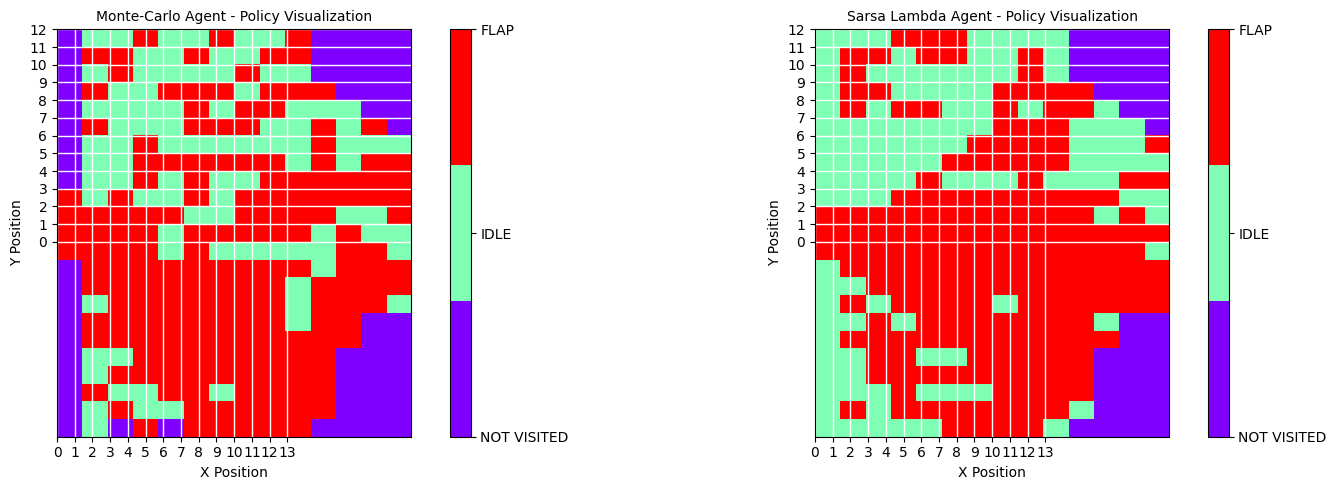

In [ ]:
plot_policy_with_actions(mc_agent,'Monte-Carlo Agent',sarsa_agent,'Sarsa lambda Agent', mode="distance", filename='/content/drive/MyDrive/3A-CS/RL/Assignement/results/policy_base_comparison.jpg')

As expected, when the bird is below the center of the gap, the policy for both agents is in majority to flap. However when the bird is above the center of the gap the bird has not yet fully learn to idle to fall below. Especially in the case of the MC Agent, the policy is still mixed. When we come closer to the pipe ( x close to 0) the policy still encourages to idle as expected. The policy of the MC agent maybe more confused due to the higher variance. It may require longer training to perform better.


We now display the state-value function for both agents trained earlier with the default parameters.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_state_value_function(agent1,agent1name, agent2,agent2name, mode,filename, height=HEIGHT, width=WIDTH, pipe_gap=PIPE_GAP):
    """
    Plots the state-value function learned by two agents
    """
    agentname = [agent1name,agent2name]

    # Initialize state values for both agents
    state_values = [None, None]

    # Determine the state space based on the mode
    if mode == "distance":
        x_dist_max = width - int(width * 0.3) - 1
        y_dist_max = height - 1 - int(pipe_gap / 2) - 1
        x_dist_range = range(x_dist_max + 1)
        y_dist_range = range(-y_dist_max, y_dist_max + 1)

        X, Y = np.meshgrid(x_dist_range, y_dist_range)

        # Compute state values for both agents
        for idx, agent in enumerate([agent1, agent2]):
            state_values[idx] = np.zeros_like(X, dtype=float)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    state = (X[i, j], Y[i, j])
                    if state in agent.Q:
                        state_values[idx][i, j] = np.max(agent.Q[state])  # Maximum Q-value for the state
                    else:
                        state_values[idx][i, j] = 0  # Default value for unvisited states

    elif mode == "screen":
        # Compute state values for both agents
        for idx, agent in enumerate([agent1, agent2]):
            state_values[idx] = np.zeros((height, width), dtype=float)
            for x in range(height):
                for y in range(width):
                    state = (x, y)
                    if state in agent.Q:
                        state_values[idx][x, y] = np.max(agent.Q[state])  # Maximum Q-value for the state
                    else:
                        state_values[idx][x, y] = 0  # Default value for unvisited states

    else:
        raise ValueError("Invalid mode. Must be 'distance' or 'screen'.")

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    for idx, state_value in enumerate(state_values):
        ax[idx].set_xticks(range(state_value.shape[1]))
        ax[idx].set_yticks(range(state_value.shape[0]))

        surf = ax[idx].imshow(state_value, cmap='viridis', extent=[0, width, -y_dist_max, y_dist_max + 1])

        ax[idx].set_title(f'{agentname[idx]} - State-Value Function', fontsize='medium')
        ax[idx].set_xlabel('X Position')
        ax[idx].set_ylabel('Y Position')
        ax[idx].grid(color='w', linestyle='-', linewidth=1)

        cbar = plt.colorbar(surf, ax=ax[idx])
        cbar.set_label('State Value (0 corresponds to unvisited states)')

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.savefig(filename)
    plt.show()


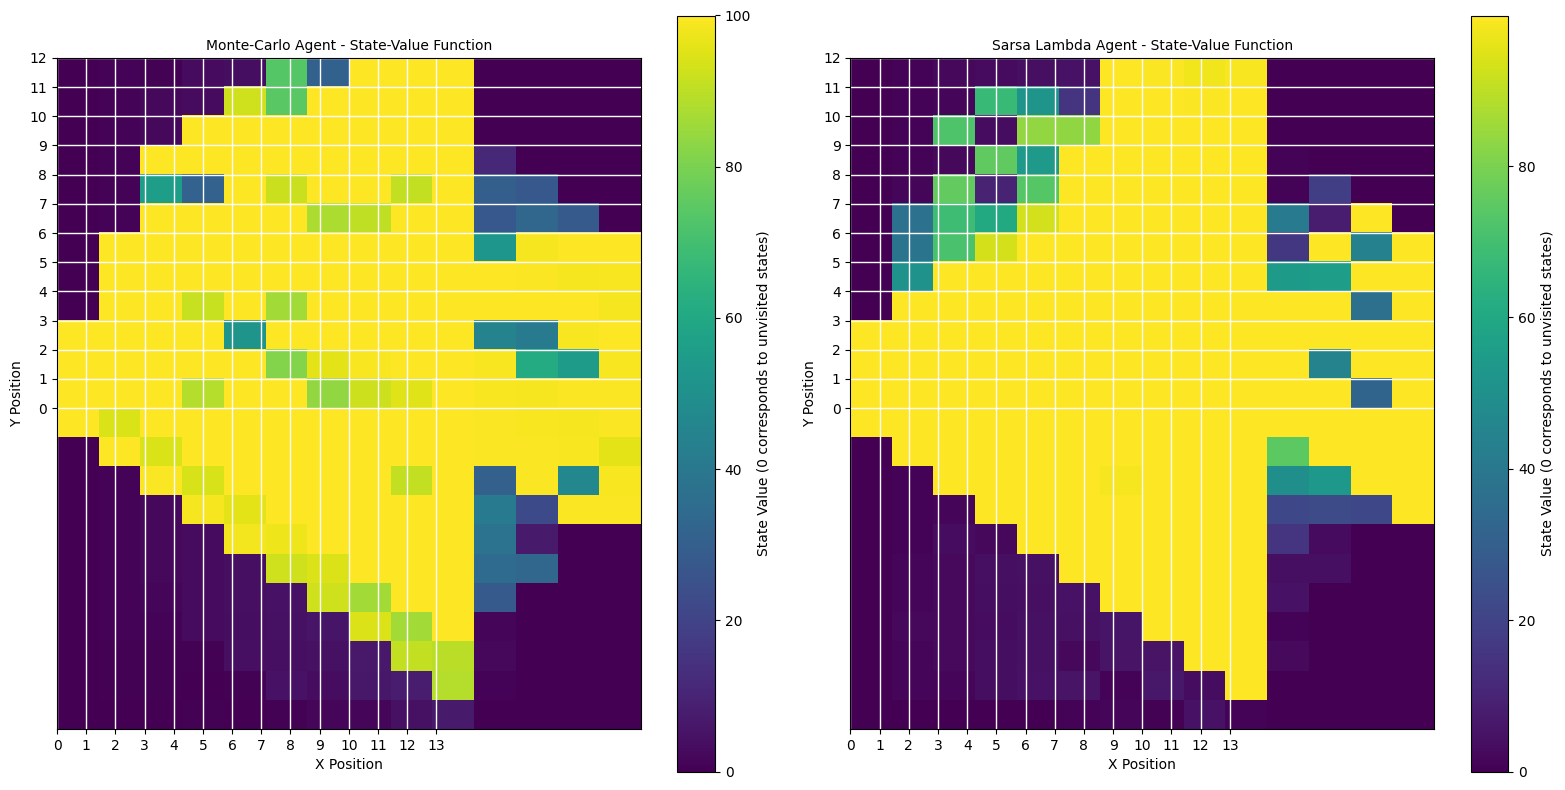

In [ ]:
plot_state_value_function( mc_agent,'Monte-Carlo Agent',sarsa_agent,'Sarsa lambda Agent', mode="distance", filename='/content/drive/MyDrive/3A-CS/RL/Assignement/results/state_value_base_comparison.jpg')

**State Coverage:** Overall both agents seem to have the same coverage for the state visited. However the Sarsa(λ) agent may be a bit more structured in his state visitation (less scattered high-value) except on the upper left, indicating clearer trajectories.

The Monte Carlo method updates state values only after entire episodes, leading to this slightly noisier value distributions. Sarsa(λ), using temporal-difference learning with eligibility traces, learns more smoothly across states, producing more continuous and structured value functions.

Overall, both agent display expected value-state distribution, as the bird has to be close to the horizontal line Y=0 when it comes near the pipe (X=0) while it has more freedom when it is further away from the pipe. The MC agent seems less sure since it display high-value state above the Y=0 line even close to the pipe.


# Hyperparemeters tuning
We will now perform some parameter sweeps to identify the best combination of paramaters for both agents while also analysing the impact of each parameter.



In [ ]:
def hyperparameter_tuning(agent_class, param_grid, filename: str, num_episodes=5000, mode='distance'):
    results = []

    # Generate all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    plt.figure(figsize=(14, 8))

    for i, params in enumerate(param_combinations):
        print(f"Training with parameters: {params}")
        agent = agent_class(mode=mode, **params)
        print("alpha: ", agent.alpha, 'gamma: ', agent.gamma, 'epsilon_decay: ', agent.epsilon_decay)

        rewards, scores = agent.train_agent(num_episodes=num_episodes)  # Train agent

        # Save the results
        results.append({
            'params': params,
            'rewards': rewards,
            'scores': scores
        })

        # Update the live plot
        plt.clf()  # Clear previous plot
        plot_live_results(results, filename)

        # Save intermediate results
        with open(f'{filename}.json', 'w') as f:
            json.dump(results, f)

        plt.pause(0.1)

    for result in results:
        params = result['params']
        scores = result['scores']

        # Apply smoothing using np.convolve
        smoothed_scores = np.convolve(scores, np.ones(50)/50, mode='valid')

        label = ', '.join([f"{key}={params[key]}" for key in params.keys()])
        plt.plot(smoothed_scores, label=label)

    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.title('Live Hyperparameter Tuning Progress')
    plt.legend()
    plt.savefig(f'{filename}.png')
    plt.show()

def plot_live_results(results,filename, window_size=50):
    for result in results:
        params = result['params']
        scores = result['scores']

        # Apply smoothing using np.convolve
        smoothed_scores = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')

        label = ', '.join([f"{key}={params[key]}" for key in params.keys()])
        plt.plot(smoothed_scores, label=label)

    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.title('Live Hyperparameter Tuning Progress')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{filename}.png')

### Parameters sweeps for the Monte-Carlo Agent

In [ ]:
param_grid = {
    'alpha': [0.1,0.2, 0.3, 0.4],
    'gamma': [0.999, 0.99, 0.9],
    'epsilon_decay': [0.9995,0.999, 0.99]
}

# ------ BE CAREFUL THIS CELL CAN TAKE MORE THAN 12H TO RUN ------ #
hyperparameter_tuning(MCAgent, param_grid,filename='/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_mc_agent', num_episodes=10000, mode='distance')


Due to the high number of combinations of parameters (36 here), the results are show in 4 plots corresponding to each $\alpha$ tested

<ipython-input-36-60b8448fec4b>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("hsv", 10)


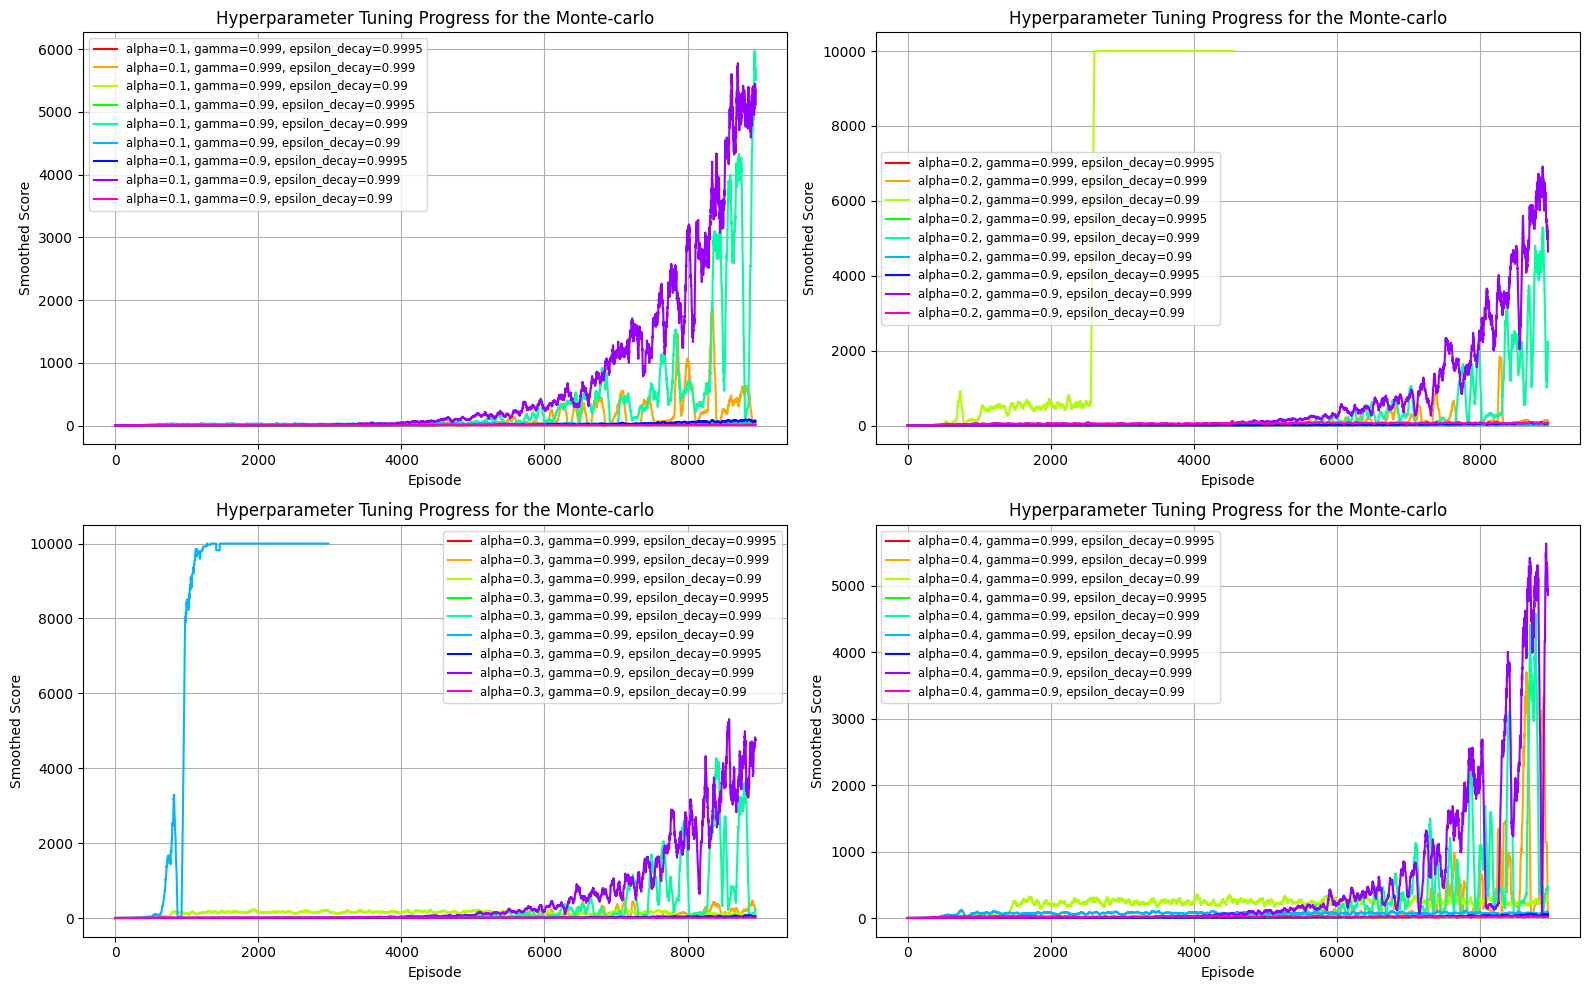

In [ ]:
with open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_mc_agent.json', 'r') as f:
    mc_results = json.load(f)

colors = plt.cm.get_cmap("hsv", 10)


def plot_subset(mc_results, start, end, subplot_index):
    plt.subplot(2, 2, subplot_index)
    for i, result in enumerate(mc_results[start:end]):
        params = result['params']
        scores = result['scores']

        # Apply smoothing using np.convolve
        smoothed_scores = np.convolve(scores, np.ones(50)/50, mode='valid')

        label = ', '.join([f"{key}={params[key]}" for key in params.keys()])
        plt.plot(smoothed_scores, label=label, color=colors(i % 10))

    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.title(f'Hyperparameter Tuning Progress for the Monte-carlo')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)

plt.figure(figsize=(16, 10))
plot_subset(mc_results, 0, 9, 1)
plot_subset(mc_results, 9, 18, 2)
plot_subset(mc_results, 18, 27, 3)
plot_subset(mc_results, 27, 36, 4)

plt.tight_layout()
plt.show()


To prevent excessively long training times, we impose a stopping criterion: training halts once the agent achieves a **score** above 10,000 a total of 2,000 times. Additionally, individual episodes are terminated when the agent reaches 10,000 points or more, as a well-trained agent could theoretically continue playing indefinitely.

### Analysis of the influence of parameter
1. **Learning Progression**  
   - Across all parameter settings,we notice that, except for two exceptions, the agent starts with very low scores and require at least between 4000 and 6000 episode to begin to improve. After more than 6000 episodes of learning, many agents started to significantly get better rewards. However the improvement is more pronounced in some cases, with certain parameter combinations yielding much higher final scores.

2. **Effect of Epsilon Decay**
  - For almost combinations of $\alpha$ and $\gamma$, except one ($\alpha=0.3$ and $\gamma=0.99$, an epsilon-decay of 0.999 yields the best results. It seems to allow a good trade-off between lots of exploration at the beginnings of the trainings, thus lower scores, and mainly exploitation toward the end pf the training. Faster decay (0.99) seems to result in earlier exploitation and then prevent optimal long-term learning (we can get a glimpse of that when looking on the plots for $\alpha=0.3/0.4$, when looking at the light green and light blue lines, that are a bit above the other before 5000 episodes. On the contrary a slower decay (0.9995) helps in continued exploration and leads to better long-term performance may require much more episodes to learn thus the poor results on the graph above.

3. **Effect of Learning Rate $\alpha$**
   - Higher values of $\alpha$ (e.g., 0.3 or 0.4) show faster initial learning, but some configurations lead to instability. Lower $\alpha$ (0.1) leads to a slower but more stable learning process.

It is harder to understand which is the better $\gamma$ parameter since it seems to be determined as a combinations and not alone. Overall it seems that the best combinations use $\gamma=0.9$ and epsilon-decay=0.999.

However there is two particular configurations perform much better reaching 10000 more than 2000 (see the plateau):
- $\alpha = 0.2$, $\gamma = 0.999$, $\epsilon$-decay = 0.99
- $\alpha = 0.3$, $\gamma = 0.99$, $\epsilon$-decay = 0.99
This last observation displayed the fastest convergence, reaching 10000 multiple times before even the 2000 episodes.


Otherwise - $\alpha = 0.2$, $\gamma = 0.9$, $\epsilon$-decay = 0.999 also appears to be a good choice but requires more episodes for training.

In [ ]:
param_grid = {
    'alpha': [0.1,0.2, 0.3, 0.4],
    'gamma': [0.999, 0.99, 0.9],
    'epsilon_decay': [0.999, 0.99],
    'epsilon': [1.0]
}
# ------ BE CAREFUL THIS CELL TAKES MORE THAN 12H TO RUN ------ #
hyperparameter_tuning(SarsaLambdaAgent, param_grid, filename='/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_sarsa', num_episodes=10000, mode='distance')

Now we assess the performance for different $\lambda$

In [ ]:
param_grid = {
    'lambda_':[0.1,0.2,0.4,0.6,0.8,0.9],
    'alpha': [0.2, 0.3],
    'epsilon': [1.0]
}
# ------ BE CAREFUL THIS CELL TAKES MORE THAN 12H TO RUN ------ #
hyperparameter_tuning(SarsaLambdaAgent, param_grid, filename= '/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha=0.3', num_episodes=10000, mode='distance')


Since it took too much time to sweeps the different parameters for our Sarsa Lambda Agent (dozens of hour), I broke the parameter sweep into multiple separate run. You can observe the results below.

<ipython-input-23-8181de248b13>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("hsv", 10)


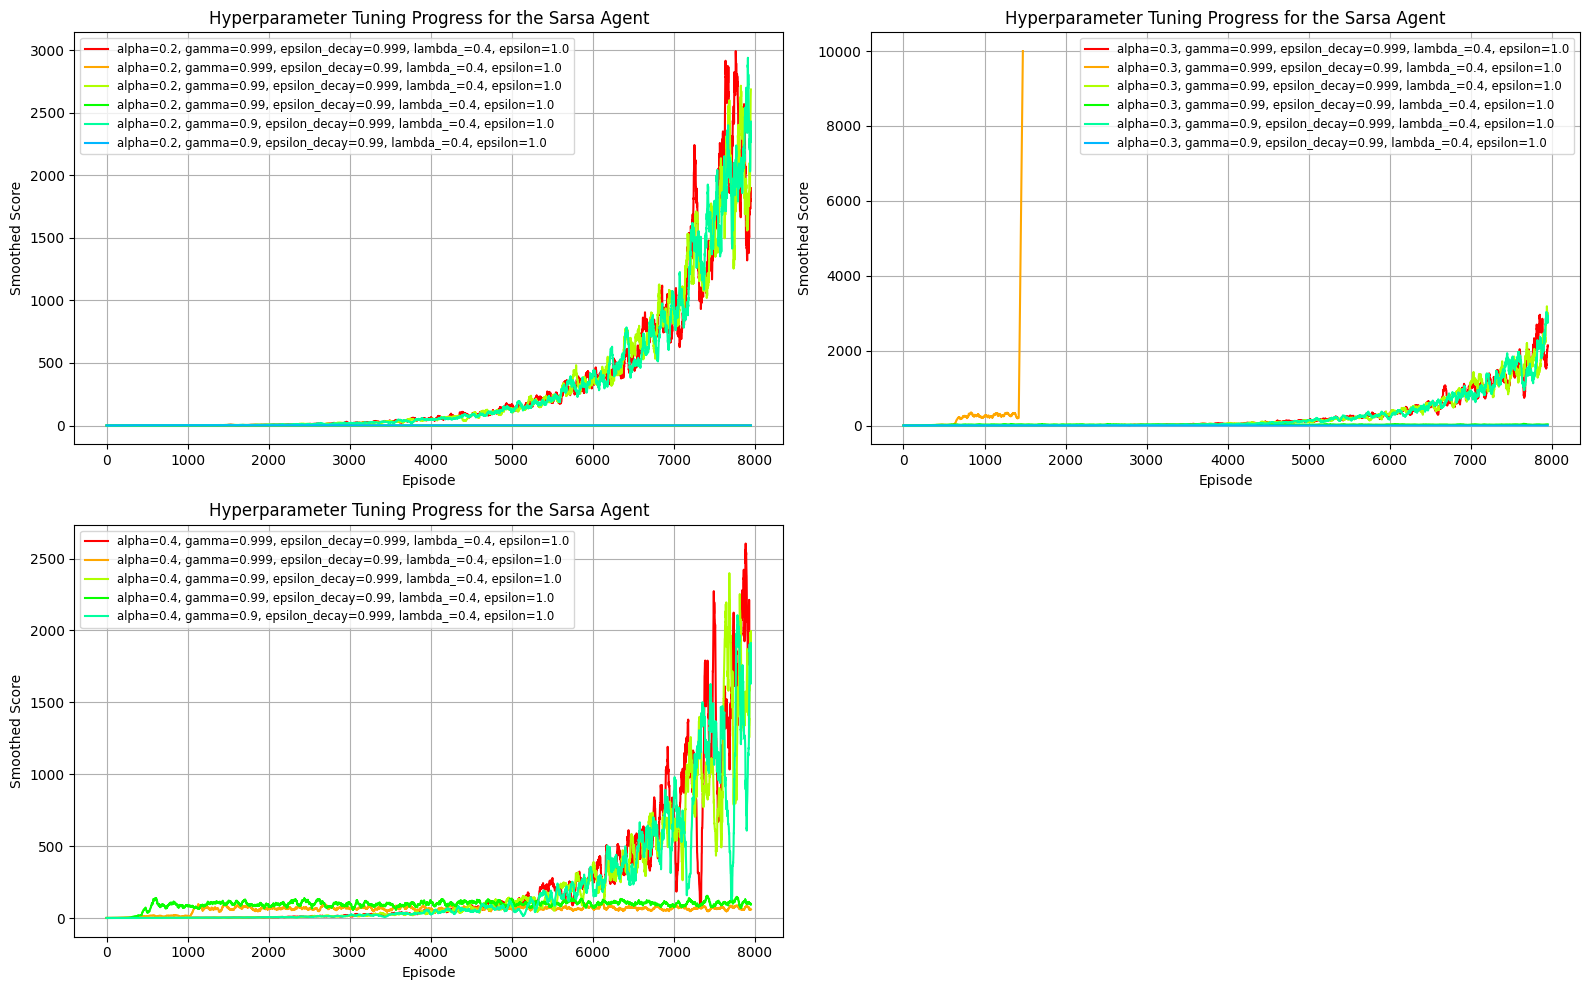

In [23]:
res1 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/sarsa_tuning_alpha0.2.json', 'r'))
res1bis = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/sarsa_tuning_alpha0.2_gamma0.9v2.json', 'r'))
res2 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/sarsa_tuning_alpha0.3.json', 'r'))
res2bis = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/sarsa_tuning_alpha0.3_gamma0.9v2.json', 'r'))
res3 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/sarsa_tuning_alpha0.4.json', 'r'))

sarsa_res = res1 + res1bis + res2 + res2bis + res3

colors = plt.cm.get_cmap("hsv", 10)


def plot_subset(results, start, end, subplot_index):
    plt.subplot(2, 2, subplot_index)
    for i, result in enumerate(results[start:end]):
        params = result['params']
        scores = result['scores']

        # Apply smoothing using np.convolve
        smoothed_scores = np.convolve(scores, np.ones(50)/50, mode='valid')

        label = ', '.join([f"{key}={params[key]}" for key in params.keys()])
        plt.plot(smoothed_scores, label=label, color=colors(i % 10))

    plt.xlabel('Episode')
    plt.ylabel('Smoothed Score')
    plt.title(f'Hyperparameter Tuning Progress for the Sarsa Agent')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)

plt.figure(figsize=(16, 10))
plot_subset(sarsa_res, 0,6, 1)
plot_subset(sarsa_res, 6, 12, 2)
plot_subset(sarsa_res, 12, 18, 3)
# plot_subset(sarsa_res, 12, 16, 4)

plt.tight_layout()
plt.show()

Due to time constraint, the training of the Sarsa agent was stop when it reaches 10000 score 50 times (same size as the window for rolling mean).

1. **Learning Rate ($\alpha$)**:  
   - $\alpha=0.2$ and $\alpha=0.3$ yield faster learning and higher rewards at the end. Also when $\alpha$ is too high ($\alpha=0.4$) this lead to high instability, as we can see on the graph, where plots are very irregular.

2. **Epsilon and Epsilon Decay Impact**:  
   - ($\epsilon$) affects exploration-exploitation balance and is initially set to 1.0 for full exploration. The decay rate of epsilon determines how quickly the agent shifts from exploration to exploitation. We can see that a too fast decay ( 0.99) leads to bad performance as the agent do not explore enough. For all combination, a decay of 0.999 yield the best results except for the exception $\alpha=0.3, \gamma=0.999$a nd a decay of 0.99.

However, we cannot infer the impact of $\gamma$ from the plot since it does not seem to have a high influence when $\gamma$ is high enough e.g. 0.9 her. I choose a discount high enough for better long-term reckoning.


Let's now explore the impact of $\lambda$.


Tuning of $\lambda$

<ipython-input-37-febda046f16f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("hsv", 10)


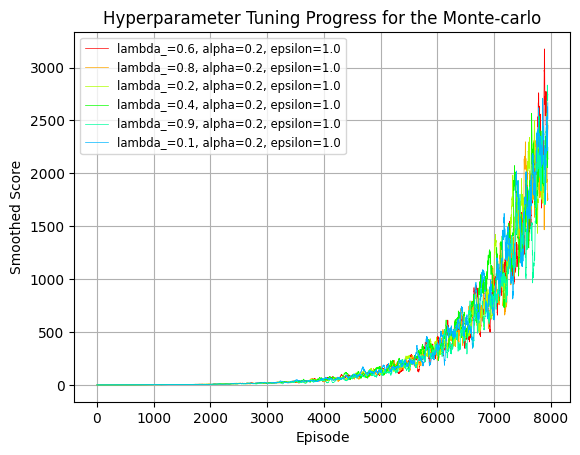

In [ ]:
res1 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.2_new.json', 'r'))
res2 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.2_v1.json', 'r'))
res3 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.2_v2.json', 'r'))

sarsa_res = res1 + res2 + res3


colors = plt.cm.get_cmap("hsv", 10)
for i, result in enumerate(sarsa_res):
        params = result['params']
        scores = result['scores']

        # Apply smoothing using np.convolve
        smoothed_scores = np.convolve(scores, np.ones(50)/50, mode='valid')

        label = ', '.join([f"{key}={params[key]}" for key in params.keys()])
        plt.plot(smoothed_scores, label=label, color=colors(i % 10), linewidth=0.5)

plt.xlabel('Episode')
plt.ylabel('Smoothed Score')
plt.title(f'Hyperparameter Tuning Progress for the Monte-carlo')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.2.png')
plt.show()

<ipython-input-24-65b46f41826e>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", 10)


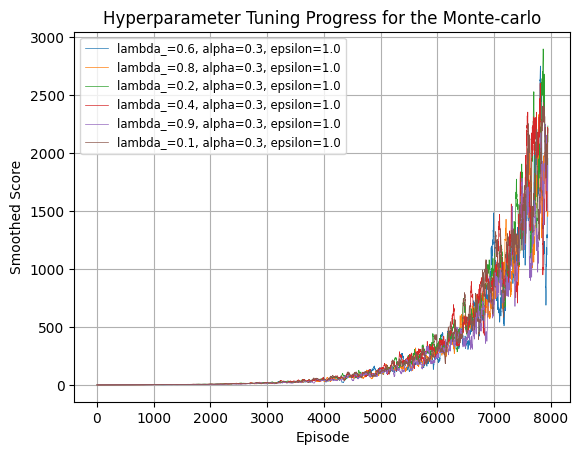

In [24]:
res1 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.3.json', 'r'))
res2 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.3_v1.json', 'r'))
res3 = json.load(open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.3_v2.json', 'r'))

sarsa_res = res1 + res2 + res3

colors = plt.cm.get_cmap("tab10", 10)
for i, result in enumerate(sarsa_res):
        params = result['params']
        scores = result['scores']

        # Apply smoothing using np.convolve
        smoothed_scores = np.convolve(scores, np.ones(50)/50, mode='valid')

        label = ', '.join([f"{key}={params[key]}" for key in params.keys()])
        plt.plot(smoothed_scores, label=label, color=colors(i % 10), linewidth=0.5)

plt.xlabel('Episode')
plt.ylabel('Smoothed Score')
plt.title(f'Hyperparameter Tuning Progress for the Monte-carlo')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/tuning_lambda_sarsa_alpha0.3.png')
plt.show()

We explore a large range of values for $\lambda$ for two different values of $\alpha$. However the results do not allow to value for $\lambda$ yield the best performance. $\lambda$ is supposed to determine how much past experience influence updates. Higher $\lambda$ values (closer to 1) promote longer credit assignment, making learning more stable but potentially slower, while lower $\lambda$ values (closer to 0) behave more like standard SARSA, updating only based on the most recent transition.

# Final Evaluation of the Agents with the best parameters

## Monte-Carlo best agent
I encounter an issue when displaying the best agent results. Since its performance depends on randomness, especially at the beginning for the exploration part, even with the same parameters and while having set `np.random.seed(42)`for reproductibility, the results may vary greatly.

In [ ]:
## ------------- Agent Training ---------------- ##
#Train the agent for 10000 episodes
mc_agent = MCAgent(mode="distance",alpha=0.3,epsilon=1.0,epsilon_decay=0.99,gamma=0.99)
rewards_mc, scores_mc = mc_agent.train_agent(num_episodes=9000)
print(f"$\epsilon$ has decayed from 1 to {mc_agent.epsilon}")
# we apply some kind of rolling mean to smooth the plot
window = 50
mc_avg_reward = np.convolve(rewards_mc, np.ones(window)/window, mode='valid')
mc_avg_score = np.convolve(scores_mc, np.ones(window)/window, mode='valid')
mc_results = {"rewards":rewards_mc, "scores":scores_mc}
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/best_mc_training.json', 'w') as f:
  json.dump(mc_results, f)


plt.plot(mc_avg_reward, label='rewards')
# plt.plot(mc_avg_score, label='scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/MC_best_training.jpg')
plt.show()


## ------------- Agent Evaluation ---------------- ##
## set epsilon to 0.0 to only use a greedy policy
rewards = []
scores = []

for _ in range(100):
  mc_agent.epsilon = 0.0
  state = process_observation(mc_agent.env.reset()[0], mc_agent.mode)
  action = mc_agent.epsilon_greedy_policy(state)
  counter = 0
  total_reward = 0
  while True:
      next_state, reward, done, _, info = mc_agent.env.step(action)
      total_reward += reward
      next_state = process_observation(next_state, mc_agent.mode)
      next_action = mc_agent.epsilon_greedy_policy(next_state)
      state, action = next_state, next_action
      if info['score'] > 10000:
          counter +=1
          # print(f"The Agent reached a score > 10000 (score: {info['score']}, reward: {total_reward}) for the {counter} times")
          if counter > 1000:
              break
      if done:
          break

  scores.append(info['score'])
  rewards.append(total_reward)
plt.plot(rewards[:], label='rewards')
plt.plot(scores[:], label='scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards and score per episode')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()
print(f"The agent reached a average score of {np.mean(scores)} and an average reward {np.mean(rewards)} ")

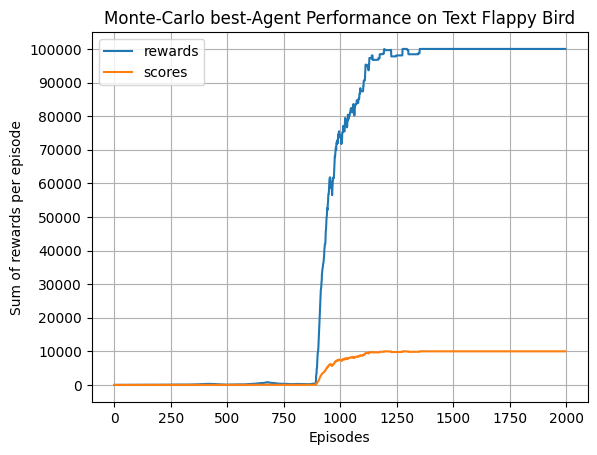

In [22]:
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/best_mc_training.json', 'r') as f:
  mc_results = json.load(f)
mc_rewards = mc_results['rewards']
mc_scores = mc_results['scores']

window=50
mc_avg_reward = np.convolve(mc_rewards, np.ones(window)/window, mode='valid')
mc_avg_score = np.convolve(mc_scores, np.ones(window)/window, mode='valid')


plt.plot(mc_avg_reward, label='rewards')
plt.plot(mc_avg_score, label='scores')
plt.yticks(np.arange(0, max(mc_rewards), step=10000))
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Monte-Carlo best-Agent Performance on Text Flappy Bird')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/MC_best_training.jpg')
plt.show()


The Agent performs very well since he reached 10000 score for 2000 times, which was the limit we set to break the training and halt each episode to avoid infinity training time. However it may not be the best agent to choose because of this sudden sharp rise. We may want to choose parameters that display more stable learning like $\alpha = 0.2$, $\gamma = 0.9$, $\epsilon$-decay = 0.999.

We also replot the state-value

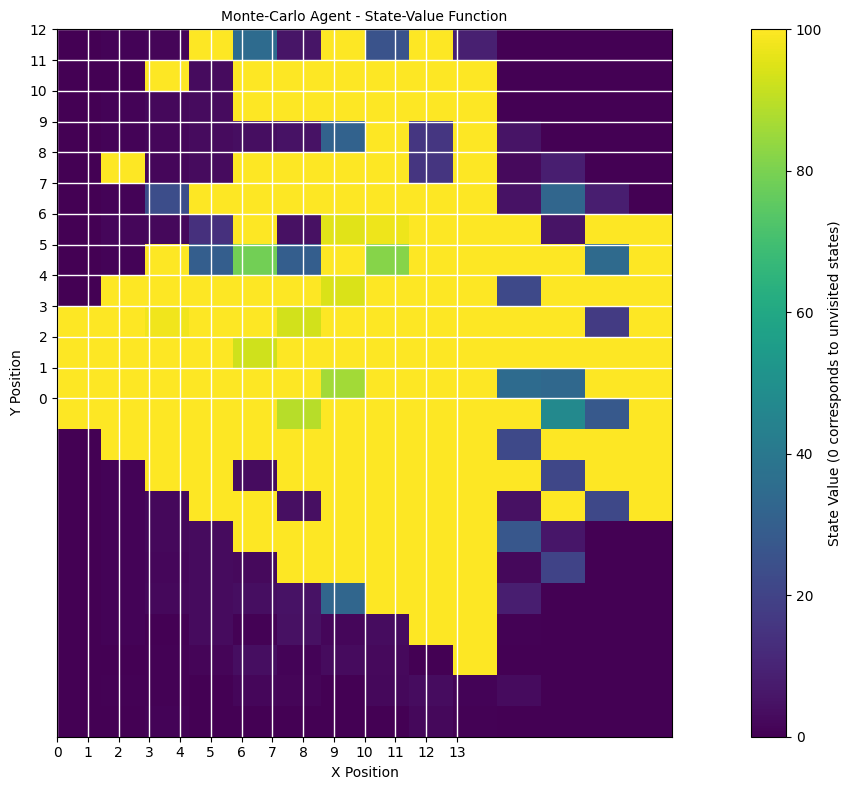

In [ ]:
# Determine the state space based on the mode

x_dist_max = WIDTH - int(WIDTH * 0.3) - 1
y_dist_max = HEIGHT - 1 - int(PIPE_GAP / 2) - 1
x_dist_range = range(x_dist_max + 1)
y_dist_range = range(-y_dist_max, y_dist_max + 1)

# Create a meshgrid for plotting
X, Y = np.meshgrid(x_dist_range, y_dist_range)


state_values = np.zeros_like(X, dtype=float)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        state = (X[i, j], Y[i, j])
        if state in mc_agent.Q:
            state_values[i, j] = np.max(mc_agent.Q[state])  # Maximum Q-value for the state
        else:
            state_values[i, j] = 0  # Default value for unvisited states

# Generate the plots side by side
plt.figure(figsize=(16, 8))


# Choose the appropriate subplot
plt.xticks(range(state_values.shape[1]))
plt.yticks(range(state_values.shape[0]))

# Use a continuous colormap to represent state values
surf = plt.imshow(state_values, cmap='viridis', extent=[0, WIDTH, -y_dist_max, y_dist_max + 1])

# Set titles, labels, and grids for each plot
plt.title(f'Monte-Carlo Agent - State-Value Function', fontsize='medium')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(color='w', linestyle='-', linewidth=1)

# Add colorbar with custom label
cbar = plt.colorbar(surf)
cbar.set_label('State Value (0 corresponds to unvisited states)')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/best_mc_agent_state_value.jpg')
plt.show()

np.save('/content/drive/MyDrive/3A-CS/RL/Assignement/state_value_best_mc_agent.npy', state_values)



## Best Sarsa($\lambda$) Agent

Here I choose to display the Sarsa agent that display the best performance but also the one whose learning improve overtime, and is more stable (so not the exeption)

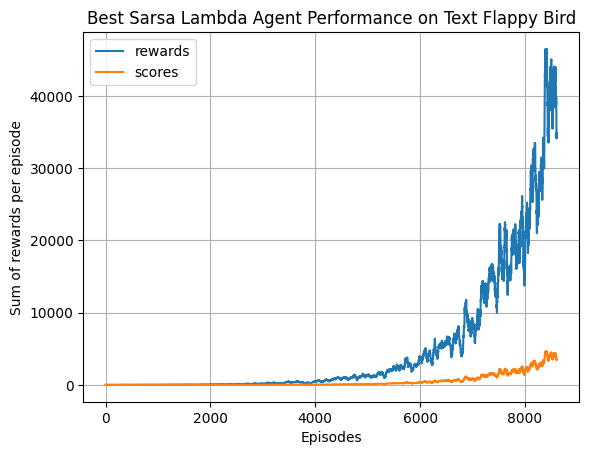

The agent reached a score of 10006 and reward 100064 


In [5]:
# ------------- Agent Training ---------------- ##
# Train the agent for 9000 episodes
sarsa_agent = SarsaLambdaAgent(mode="distance", lambda_=0.4,alpha=0.3, epsilon_decay=0.999, gamma=0.999, epsilon=1.0 )
rewards_sarsa, scores_sarsa = sarsa_agent.train_agent(num_episodes=9000)
window = 50
sarsa_avg_reward = np.convolve(rewards_sarsa, np.ones(window)/window, mode='valid')
sarsa_avg_score = np.convolve(scores_sarsa, np.ones(window)/window, mode='valid')

sarsa_results = {"rewards":rewards_mc, "scores":scores_mc}
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/results/best_sarsa_training.json', 'w') as f:
            json.dump(sarsa_results, f)



plt.plot(sarsa_avg_reward, label='rewards')
plt.plot(sarsa_avg_score, label='scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Best Sarsa Lambda Agent Performance on Text Flappy Bird')
plt.legend()
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/sarsa_best_training.jpg')
plt.show()


## ------------- Agent Evaluation ---------------- ##
## set epsilon to 0.0 to only use a greedy policy
rewards= []
scores = []

for _ in range(100):
  ## set epsilon to 0.0 to only use a greedy policy
  sarsa_agent.epsilon = 0.0
  state = process_observation(sarsa_agent.env.reset()[0], sarsa_agent.mode)
  action = sarsa_agent.epsilon_greedy_policy(state)
  counter = 0
  total_reward = 0
  while True:
      next_state, reward, done, _, info = sarsa_agent.env.step(action)
      total_reward += reward
      next_state = process_observation(next_state, sarsa_agent.mode)
      next_action = sarsa_agent.epsilon_greedy_policy(next_state)
      state, action = next_state, next_action
      if info['score'] > 10000:
          # print(f"The Agent reached a score > 10000 (score: {info['score']}, reward: {total_reward}) for the {counter} times")
          if counter > 1000:
              break
      if done:
          break
      scores.append(info['score'])
      rewards.append(total_reward)

print(f"The agent reached a score of {np.mean(scores)} and reward {np.mean(rewards)} ")



We nom plot the state value.

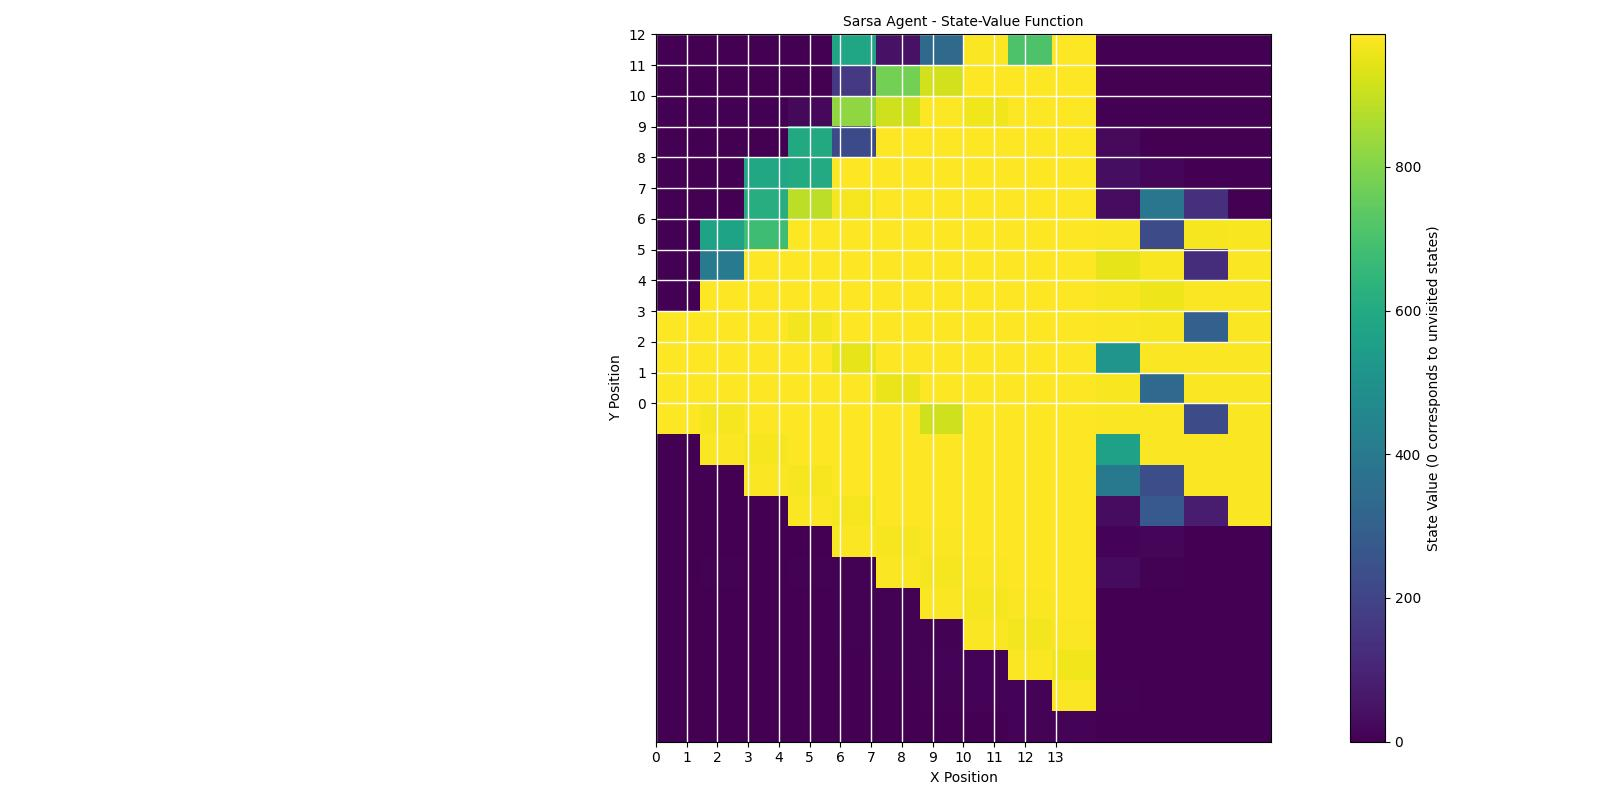

In [10]:
# Determine the state space based on the mode

x_dist_max = WIDTH - int(WIDTH * 0.3) - 1
y_dist_max = HEIGHT - 1 - int(PIPE_GAP / 2) - 1
x_dist_range = range(x_dist_max + 1)
y_dist_range = range(-y_dist_max, y_dist_max + 1)

# Create a meshgrid for plotting
X, Y = np.meshgrid(x_dist_range, y_dist_range)


state_values = np.zeros_like(X, dtype=float)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        state = (X[i, j], Y[i, j])
        if state in mc_agent.Q:
            state_values[i, j] = np.max(sarsa_agent.Q[state])  # Maximum Q-value for the state
        else:
            state_values[i, j] = 0  # Default value for unvisited states

# Generate the plots side by side
plt.figure(figsize=(16, 8))


# Choose the appropriate subplot
plt.xticks(range(state_values.shape[1]))
plt.yticks(range(state_values.shape[0]))

# Use a continuous colormap to represent state values
surf = plt.imshow(state_values, cmap='viridis', extent=[0, WIDTH, -y_dist_max, y_dist_max + 1])

# Set titles, labels, and grids for each plot
plt.title(f'Sarsa Agent - State-Value Function', fontsize='medium')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(color='w', linestyle='-', linewidth=1)

# Add colorbar with custom label
cbar = plt.colorbar(surf)
cbar.set_label('State Value (0 corresponds to unvisited states)')

plt.tight_layout()  # Adjust layout to avoid overlap
plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/results/best_sarsa_agent_state_value.jpg')
plt.show()

np.save('/content/drive/MyDrive/3A-CS/RL/Assignement/results/best_sarsa_agent_state_value.npy', state_values)

# from PIL import Image

# img = Image.open('/content/drive/MyDrive/3A-CS/RL/Assignement/results/best_sarsa_agent_state_value.jpg')
# img

In [ ]:
## ------------- Sarsa Agent Training ---------------- ##
#Train the agent for 10000 episodes
sarsa_agent = SarsaLambdaAgent(mode="distance", gamma=0.99, alpha=0.3, epsilon=1.0, lambda_=0.95, epsilon_decay=0.999)
rewards_sarsa, scores_sarsa = sarsa_agent.train_agent(num_episodes=10000)
window = 50
sarsa_avg_reward = np.convolve(rewards_sarsa, np.ones(window)/window, mode='valid')
sarsa_avg_score = np.convolve(scores_sarsa, np.ones(window)/window, mode='valid')

sarsa_results = {"rewards":rewards_sarsa, "scores":scores_sarsa}
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/results/best_sarsa_training.json', 'w') as f:
            json.dump(sarsa_results, f)

## ------------- MC Agent Training ---------------- ##
#Train the agent for 10000 episodes
mc_agent = MCAgent(mode="distance")
rewards_mc, scores_mc = mc_agent.train_agent(num_episodes=8000)
print(f"$\epsilon$ has decayed from 1 to {mc_agent.epsilon}")
# we apply some kind of rolling mean to smooth the plot
window = 50
mc_avg_reward = np.convolve(rewards_mc, np.ones(window)/window, mode='valid')
mc_avg_score = np.convolve(scores_mc, np.ones(window)/window, mode='valid')
mc_results = {"rewards":rewards_mc, "scores":scores_mc}
with open(f'/content/drive/MyDrive/3A-CS/RL/Assignement/results/best_mc_training.json', 'w') as f:
  json.dump(mc_results, f)


# Set figure size before subplots
plt.figure(figsize=(14, 6))  # Change width and height here

plt.subplot(1, 2, 1)
plt.plot(mc_avg_reward, label='MC rewards')
# plt.plot(mc_avg_score, label='MC scores')
plt.plot(sarsa_avg_reward, label='Sarsa(λ) rewards')
# plt.plot(sarsa_avg_score, label='Sarsa(λ) scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.yscale('log')
plt.title('Agent Performance on Text Flappy Bird (log scale)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mc_avg_reward, label='MC rewards')
# plt.plot(mc_avg_score, label='MC scores')
plt.plot(sarsa_avg_reward, label='Sarsa(λ) rewards')
# plt.plot(sarsa_avg_score, label='Sarsa(λ) scores')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards per episode')
plt.title('Agent Performance on Text Flappy Bird')
plt.legend()

plt.savefig('/content/drive/MyDrive/3A-CS/RL/Assignement/comparison_best_training.jpg')
plt.show()



We also plot the policy for these "best" agents.

In [ ]:
plot_policy_with_actions(mc_agent,'Monte-Carlo Agent',sarsa_agent,'Sarsa lambda Agent', mode="distance", filename='/content/drive/MyDrive/3A-CS/RL/Assignement/best_agents_policy_plot.jpg')

And the state-value functions.

In [ ]:
plot_state_value_function( mc_agent,'Monte-Carlo Agent',sarsa_agent,'Sarsa lambda Agent', mode="distance", filename='/content/drive/MyDrive/3A-CS/RL/Assignement/best_agent_state_value_plot.jpg')